<a id='top'></a>

# Experiments to Malaria Project

#### This notebook describes performed experiments, qualitative analysis and results discussion

<a id='imports'></a>
### Imports

In [ ]:
! pip install shap lime synapseclient

     |████████████████████████████████| 356 kB 6.1 MB/s 
     |████████████████████████████████| 275 kB 30.6 MB/s 
     |████████████████████████████████| 209 kB 47.0 MB/s 
     |████████████████████████████████| 3.2 MB 47.9 MB/s 
  Created wheel for shap: filename=shap-0.39.0-cp37-cp37m-linux_x86_64.whl size=491650 sha256=7b208384206521c757ad1f875bcf4a0665fd40f6a657e1e9dfddde793fc52eb1
  Stored in directory: /root/.cache/pip/wheels/ca/25/8f/6ae5df62c32651cd719e972e738a8aaa4a87414c4d2b14c9c0
  Created wheel for lime: filename=lime-0.2.0.1-py3-none-any.whl size=283857 sha256=3d0b67ea263bb8a126b6c266004e5f3c47e5da293f82953fa4d516d2227ef3e3
  Stored in directory: /root/.cache/pip/wheels/ca/cb/e5/ac701e12d365a08917bf4c6171c0961bc880a8181359c66aa7
  Created wheel for secretstorage: filename=SecretStorage-2.3.1-py3-none-any.whl size=13975 sha256=4807bed80ce3fb232f0b1f1b5e719063f077d1d414724b804a0ce7d1009be0ab
  Stored in directory: /root/.cache/pip/wheels/13/dc/30/1858f4ebf2be9b67b180c6a4a31

In [ ]:
%matplotlib inline

import os, itertools
import zipfile as zp
import synapseclient as syna
from getpass import getpass

import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns

#import shap
#import math
#import lime
#from lime import lime_tabular

#from termcolor import colored
from datetime import datetime

from sklearn import metrics
from sklearn.model_selection import KFold, train_test_split

from xgboost import XGBClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC

import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

<a id='functions_definition'></a>
## Functions definition

In [ ]:
# Function to plot a histogram that shows the number of NaN values for each column.
def plot_hist_nan(df: pd.DataFrame, plot_name):

    nan_df = pd.DataFrame(df.isna().sum().tolist(), df.columns.tolist()).reset_index()
    nan_df.columns = ['column_name', 'total_nan']
    nan_df['nan_perc'] = 100*round(nan_df['total_nan']/len(df),3)
    nan_df = nan_df.sort_values('total_nan', ascending=False)
    nan_df = nan_df[nan_df['total_nan'] > 0]

    fig, ax = plt.subplots(figsize=(10,6))

    sns.barplot(x="nan_perc", y="column_name", data=nan_df)
    ax.set_ylabel('Columns', fontsize = 10)
    ax.set_xlabel('NaN %', fontsize = 10)
    ax.tick_params(length=10, width=2, labelsize=10)

    dst = "../out/"
    if os.path.isdir(dst) == False:
        os.makedirs(dst)
    dst = dst + "/" + plot_name + ".pdf"
    plt.savefig(dst, bbox_inches = 'tight')

    plt.show()

In [ ]:
# Consusion matrix plot
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    # print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=90)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

In [ ]:
# Model performance statistics
def generate_performance_stats(y_test, y_pred):
    target_names = ['Outro Tratamento', 'Tratamento 11']
    cm = metrics.confusion_matrix(y_test, y_pred)
    print("Accuracy: {}\n".format(metrics.accuracy_score(y_test,y_pred)))
    print("Auc: {}\n".format(metrics.roc_auc_score(y_test,y_pred)))
    #print("Log loss: {}\n".format(metrics.log_loss(y_test,y_pred)))
    print("Confusion Matrix: \n{}\n".format(pd.crosstab(y_test, y_pred, rownames=['Actual'], colnames=['Predicted'])))
    print("Classification Report: \n{}\n".format(metrics.classification_report(y_test, y_pred, target_names=target_names)))


In [ ]:
# Create balanced dataset
def create_balanced_dataset(df: pd.DataFrame, percent):
    # Class count
    count_class_0, count_class_1 = df['target'].value_counts() * percent
    count_class_0 = int(count_class_0)
    count_class_1 = int(count_class_1)

    # Divide by class
    df_class_0 = df[df['target'] == 0]
    df_class_1 = df[df['target'] == 1]

    df_class_1 = df_class_1.sample(count_class_1, random_state=1)

    df_class_0_under = df_class_0.sample(count_class_1, random_state=1)
    df_balanced = pd.concat([df_class_0_under, df_class_1], axis=0)

    return df_balanced

In [ ]:
# Perform Cross-validation
def perform_cv(df_train, models, n_folds, use_oversampling):

    results = []
    mean_fpr = np.linspace(0, 1, 100)
    models_predictions = {}

    for model_alias in models:

        print("Model: {}\n".format(model_alias))
        y_preds = []
        y_probs = []
        y_tests = []
        tprs = []
        aucs = []
        thresholds = []
        model = models[model_alias]

        i = 0
        kf = KFold(n_splits=n_folds, random_state=13, shuffle=True)
        #model_predicted = []
        #model_gt = []

        for index in kf.split(df_train):

            print("Fold[{}]\n".format(i+1))

            X_train, X_test = df_train.iloc[index[0]], df_train.iloc[index[1]]

            if use_oversampling:
                X_train = create_balanced_dataset(X_train, 1.0)

            y_train = X_train['target']
            X_train = X_train.drop(['target'], axis = 1)

            y_test = X_test['target']
            X_test = X_test.drop(['target'], axis = 1)

            model_fit, y_pred, y_pred_proba = evaluate_model(model, X_train, X_test, y_train, y_test)

            #y_pred = y_pred_proba[:,1] > thresh
            #y_pred = y_pred.astype(int)
            #model_predicted = np.concatenate((np.array(model_predicted),y_pred))
            #model_gt = np.concatenate((np.array(model_gt),y_test))

            #generate_performance_stats(y_test, y_pred)

            # Compute ROC curve and area the curve
            fpr, tpr, threshold = metrics.roc_curve(y_test, y_pred_proba[:,1])
            prec, rec, tre = metrics.precision_recall_curve(y_test, y_pred_proba[:,1])

            y_preds = np.append(y_preds, y_pred)
            y_probs = np.append(y_probs, y_pred_proba[:,1])
            y_tests = np.append(y_tests, y_test)

            tprs.append(np.interp(mean_fpr, fpr, tpr))
            tprs[-1][0] = 0.0
            roc_auc = metrics.auc(fpr, tpr)
            aucs.append(roc_auc)
            thresholds.append(threshold)
            i = i + 1

        generate_performance_stats(y_preds, y_tests)

        result = RESULT(model_alias, y_preds, y_probs, y_tests, tprs, aucs, thresholds)
        results.append(result)
        models_predictions[model_alias] = (y_preds, y_tests)
        print("########################################################\n")

    return results, models_predictions

In [ ]:
def evaluate_model(model, X_train: pd.DataFrame, X_test: pd.DataFrame, y_train: pd.DataFrame, y_test: pd.DataFrame):
    """
    Used to evaluate a given model. Just an API wrapper.
    Returns the fitted model along with the predictions generated for the test set
    """
    model.fit(X_train, y_train)
    y_preds = model.predict(X_test)
    y_preds_proba = model.predict_proba(X_test)
    return model, y_preds, y_preds_proba

In [ ]:
class RESULT(object):

    def __init__(self, model_name, y_pred, y_prob, y_test, tprs, aucs, thresholds):
        self.model_name = model_name
        self.y_pred = y_pred
        self.y_prob = y_prob
        self.y_test = y_test
        self.tprs = tprs
        self.aucs = aucs
        self.thresholds = thresholds

In [ ]:
def plot_roc_curve(results, file_name):

    plt.figure(figsize=(10,8))
    mean_fpr = np.linspace(0, 1, 100)
    tprs = []
    i = 0

    colors = ['r','b','g']

    for idx,result in enumerate(results):

        plt.plot([0, 1], [0, 1], linestyle='--', lw=2, color='r', alpha=.8)
        mean_tpr = np.mean(result.tprs, axis=0)
        mean_tpr[-1] = 1.0
        std_auc = np.std(result.aucs)
        avg_auc = metrics.roc_auc_score(result.y_test, result.y_pred)

        plt.plot(mean_fpr, mean_tpr, color=colors[idx],
                 label=result.model_name + ' (AUC = %0.3f $\pm$ %0.3f)' % (avg_auc, std_auc), lw=2, alpha=0.8)

        std_tpr = np.std(result.tprs, axis=0)
        tprs_upper = np.minimum(mean_tpr + std_tpr, 1)
        tprs_lower = np.maximum(mean_tpr - std_tpr, 0)

        if i == 0:
            plt.fill_between(mean_fpr, tprs_lower, tprs_upper, color=colors[idx], alpha=.2)
        else:
            plt.fill_between(mean_fpr, tprs_lower, tprs_upper, color=colors[idx], alpha=.2)
        i = i + 1

    plt.plot([0, 1], [0, 1], linestyle='--', lw=2, color='black', label='Chance', alpha=.8)
    plt.xlim([-0.05, 1.05])
    plt.ylim([-0.05, 1.05])
    plt.xlabel('1 - Specificity', size=15)
    plt.ylabel('Sensitivity', size=15)
    plt.legend(loc="lower right", fontsize=14)
    plt.title('ROC CURVE')

    dst = "../out/"
    if os.path.isdir(dst) == False:
        os.makedirs(dst)
    dst = dst + "/" + file_name + ".pdf"
    plt.savefig(dst, bbox_inches = 'tight')

    plt.show()


<a id='loading_dataset'></a>
## Load dataset

In [ ]:
 # Getting BD from Synapse
 syn = syna.Synapse()
 syn.login(input('Sybapse User: '), getpass('Passwd:'))

 # Obtain a pointer and download the data
 # sivep_completo.csv.zip - https://www.synapse.org/#!Synapse:syn24225699
 dataset = syn.get(entity='syn25713874')

 # Get the path to the local copy of the data file
 filepath = dataset.path

 with zp.ZipFile(filepath,"r") as zip_ref:
    zip_ref.extractall("")


Sybapse User: cbeluzo
Passwd:··········
Welcome, Carlos Eduardo Beluzo!



Adicionei low_memory=False, por causa do warning de dtype

In [ ]:
df_full = pd.read_csv('./dados/sivep_data.csv', sep=';', low_memory=False, encoding="ISO-8859-1")
df_full.shape

(3737123, 51)

In [ ]:
df_full.head()

,ï»¿uid,ano,cod_noti,dt_notif,dt_envlo,dt_digit,sem_noti,tipo_lam,uf_notif,mun_noti,cod_unin,cod_agen,dt_nasci,id_pacie,id_dimea,sexo,raca,pais_res,uf_resid,mun_resi,loc_resi,sintomas,dt_sinto,cod_ocup,uf_infec,pais_inf,mun_infe,loc_infe,dt_exame,res_exam,qtd_para,qtd_cruz,dt_trata,esquema,hemoparasi,exame,examinador,id_lvc,gestante,vivax,falciparum,niv_esco,id_pacie_anos,nu_predi_infe,nu_habit_infe,zona_infe,categori_infe,nu_predi_resi,nu_habit_resi,zona_resi,categori_resi
0,1,2007,1,2007-01-02,2011-03-23,2007-01-03,1.0,Detecção Passiva,AC,120042,11,209890.0,NaN,6.0,Anos,Feminino,NaN,BRASIL,Acre,120042.0,53.0,Com,2007-01-01,Doméstica,Acre,BRASIL,120042.0,53.0,2007-01-02,Vivax,NaN,++,2007-07-02,"Infecções pelo P. vivax, ou P. ovale com Cloro...",NaN,NaN,NaN,Não LVC,Não se aplica,NaN,NaN,Não se aplica,6,85.0,201.0,Rural,Ramal,85.0,201.0,Rural,Ramal
1,2,2007,2,2007-01-02,2011-03-23,2007-01-03,1.0,Detecção Passiva,AC,120042,11,209890.0,NaN,2.0,Anos,Masculino,NaN,BRASIL,Acre,120042.0,53.0,Com,2007-01-02,Doméstica,Acre,BRASIL,120042.0,53.0,2007-01-02,Vivax,NaN,< +/2,2007-07-02,"Infecções pelo P. vivax, ou P. ovale com Cloro...",NaN,NaN,NaN,Não LVC,Não se aplica,NaN,NaN,Não se aplica,2,85.0,201.0,Rural,Ramal,85.0,201.0,Rural,Ramal
2,3,2007,14,2007-01-02,2011-03-23,2007-01-03,1.0,Detecção Passiva,AC,120042,11,208614.0,1959-04-30,47.0,Anos,Feminino,NaN,BRASIL,Acre,120042.0,53.0,Com,2007-01-01,Doméstica,Acre,BRASIL,120042.0,53.0,2007-01-02,Vivax,NaN,< +/2,2007-01-02,"Infecções pelo P. vivax, ou P. ovale com Cloro...",NaN,NaN,NaN,Não LVC,Não,NaN,NaN,Analfabeto,47,85.0,201.0,Rural,Ramal,85.0,201.0,Rural,Ramal
3,4,2007,18,2007-01-02,2011-03-23,2007-01-03,1.0,Detecção Passiva,AC,120042,11,208614.0,NaN,15.0,Anos,Feminino,NaN,BRASIL,Acre,120042.0,53.0,Com,2006-12-30,Doméstica,Acre,BRASIL,120042.0,53.0,2007-01-02,Vivax,NaN,+/2,2007-01-02,"Infecções pelo P. vivax, ou P. ovale com Cloro...",NaN,NaN,NaN,Não LVC,Não,NaN,NaN,5ª a 8ª série incompleta do EF,15,85.0,201.0,Rural,Ramal,85.0,201.0,Rural,Ramal
4,5,2007,24,2007-01-02,2011-03-23,2007-01-06,1.0,Detecção Passiva,AC,120042,11,209890.0,1984-12-13,22.0,Anos,Masculino,NaN,BRASIL,Acre,120042.0,53.0,Com,2007-01-02,Agricultura,Acre,BRASIL,120042.0,53.0,2007-01-03,Vivax,NaN,+,2007-01-03,"Infecções pelo P. vivax, ou P. ovale com Cloro...",NaN,NaN,NaN,Não LVC,Não se aplica,NaN,NaN,5ª a 8ª série incompleta do EF,22,85.0,201.0,Rural,Ramal,85.0,201.0,Rural,Ramal


## Data Preprocessing

In [ ]:
df_prep = df_full.copy()

In [ ]:
df_prep.columns

Index(['ï»¿uid', 'ano', 'cod_noti', 'dt_notif', 'dt_envlo', 'dt_digit',
       'sem_noti', 'tipo_lam', 'uf_notif', 'mun_noti', 'cod_unin', 'cod_agen',
       'dt_nasci', 'id_pacie', 'id_dimea', 'sexo', 'raca', 'pais_res',
       'uf_resid', 'mun_resi', 'loc_resi', 'sintomas', 'dt_sinto', 'cod_ocup',
       'uf_infec', 'pais_inf', 'mun_infe', 'loc_infe', 'dt_exame', 'res_exam',
       'qtd_para', 'qtd_cruz', 'dt_trata', 'esquema', 'hemoparasi', 'exame',
       'examinador', 'id_lvc', 'gestante', 'vivax', 'falciparum', 'niv_esco',
       'id_pacie_anos', 'nu_predi_infe', 'nu_habit_infe', 'zona_infe',
       'categori_infe', 'nu_predi_resi', 'nu_habit_resi', 'zona_resi',
       'categori_resi'],
      dtype='object')

**Converter colunas de datas para datetime**

In [ ]:
date_cols = ['dt_sinto', 'dt_notif', 'dt_exame', 'dt_trata']
df_prep[date_cols] = df_prep[date_cols].apply(pd.to_datetime,  errors='coerce')
df_prep[date_cols].head()

,dt_sinto,dt_notif,dt_exame,dt_trata
0,2007-01-01,2007-01-02,2007-01-02,2007-07-02
1,2007-01-02,2007-01-02,2007-01-02,2007-07-02
2,2007-01-01,2007-01-02,2007-01-02,2007-01-02
3,2006-12-30,2007-01-02,2007-01-02,2007-01-02
4,2007-01-02,2007-01-02,2007-01-03,2007-01-03


**Deixar somente registros a partir de 2011 considerando a data em que o paciente sentiu os primeiros sintomas da malária: dt_sinto**

In [ ]:
print(df_prep.shape)
df_prep = df_prep[df_prep['dt_sinto'] > pd.to_datetime("2010-12-31")]
print(df_prep.shape)

(3737123, 51)
(1896254, 51)


In [ ]:
#Drop ununsable features
cols_to_drop = ['ï»¿uid', 'ano', 'cod_noti', 'dt_envlo', 'dt_digit', 'sem_noti', 'uf_notif', 'mun_noti', 'cod_unin',
                'cod_agen', 'dt_nasci', 'pais_res', 'uf_resid', 'mun_resi', 'loc_resi', 'examinador',
                'nu_predi_infe', 'nu_habit_infe', 'nu_predi_resi', 'nu_habit_resi', 'zona_resi', 'categori_resi',
                'id_pacie_anos']
df_prep = df_prep.drop(columns=cols_to_drop, axis=1)

In [ ]:
df_prep.columns

Index(['dt_notif', 'tipo_lam', 'id_pacie', 'id_dimea', 'sexo', 'raca',
       'sintomas', 'dt_sinto', 'cod_ocup', 'uf_infec', 'pais_inf', 'mun_infe',
       'loc_infe', 'dt_exame', 'res_exam', 'qtd_para', 'qtd_cruz', 'dt_trata',
       'esquema', 'hemoparasi', 'exame', 'id_lvc', 'gestante', 'vivax',
       'falciparum', 'niv_esco', 'zona_infe', 'categori_infe'],
      dtype='object')

In [ ]:
cols = df_prep.columns
for col in cols:
    print(col, ": ", df_prep[col].dtype)
    print(df_prep[col].unique(), "\n")

dt_notif :  datetime64[ns]
['2009-12-30T00:00:00.000000000' '2011-01-31T00:00:00.000000000'
 '2011-02-17T00:00:00.000000000' ... '2020-06-13T00:00:00.000000000'
 '2020-06-14T00:00:00.000000000' '2020-06-16T00:00:00.000000000'] 

tipo_lam :  object
['Detecção Ativa' 'LVC (ficha antiga)' 'Detecção Passiva'] 

id_pacie :  float64
[3.100e+01 1.800e+01 2.100e+01 9.000e+00 4.600e+01 2.000e+00 1.200e+01
 2.600e+01 6.000e+00 1.900e+01 2.400e+01 3.200e+01 4.700e+01 3.600e+01
 8.000e+00 2.900e+01 2.300e+01 1.700e+01 1.000e+01 6.200e+01 1.600e+01
 5.700e+01 4.100e+01 2.700e+01 1.500e+01 2.200e+01 1.100e+01 3.700e+01
 3.800e+01 2.000e+01 3.000e+01 3.900e+01 4.300e+01 3.500e+01 6.600e+01
 4.800e+01 3.300e+01 2.800e+01 6.000e+01 4.000e+00 6.400e+01 5.300e+01
 5.000e+01 1.400e+01 3.400e+01 5.600e+01 4.000e+01 7.000e+00 6.100e+01
 3.000e+00 5.400e+01 4.900e+01 5.000e+00 7.400e+01 5.500e+01 5.100e+01
 1.000e+00 2.500e+01 4.200e+01 5.900e+01 1.300e+01 7.200e+01 6.700e+01
 4.500e+01 5.800e+01 6.900e+01 4

**Remover registros onde id_lvc é LVC**

In [ ]:
print(df_prep.shape)
df_prep = df_prep[df_prep['id_lvc'] != 'LVC']
print(df_prep.shape)

(1896254, 28)
(1594530, 28)


**Remover coluna id_lvc pois ela agora só possui um único valor**

In [ ]:
df_prep['id_lvc'].unique()

array(['Não LVC'], dtype=object)

In [ ]:
df_prep.drop(columns='id_lvc', axis=1, inplace=True)

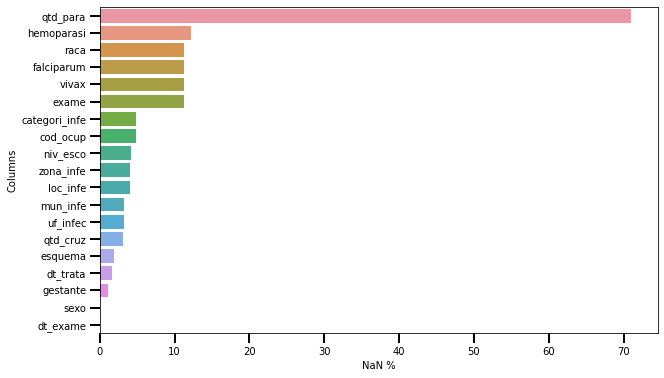

In [ ]:
# Let's see the barplot that shows the number of nan values by column
plot_hist_nan(df_prep, 'barplot_nan')

In [ ]:
nan_df = pd.DataFrame(df_prep.isna().sum().tolist(), df_prep.columns.tolist()).reset_index()
nan_df.columns = ['column_name', 'total_nan']
nan_df['nan_perc'] = 100*round(nan_df['total_nan']/len(df_prep),3)
nan_df = nan_df.sort_values('total_nan', ascending=False)
nan_df.head()

,column_name,total_nan,nan_perc
15,qtd_para,1132107,71.0
19,hemoparasi,193855,12.2
5,raca,178195,11.2
23,falciparum,178150,11.2
22,vivax,178150,11.2


**Remover a coluna qtd_para pois tem mais de 70% de valores faltantes.**

In [ ]:
print(df_prep.shape)
df_prep.drop(columns=['qtd_para'], axis=1, inplace=True)
print(df_prep.shape)
df_prep.columns

(1594530, 27)
(1594530, 26)


Index(['dt_notif', 'tipo_lam', 'id_pacie', 'id_dimea', 'sexo', 'raca',
       'sintomas', 'dt_sinto', 'cod_ocup', 'uf_infec', 'pais_inf', 'mun_infe',
       'loc_infe', 'dt_exame', 'res_exam', 'qtd_cruz', 'dt_trata', 'esquema',
       'hemoparasi', 'exame', 'gestante', 'vivax', 'falciparum', 'niv_esco',
       'zona_infe', 'categori_infe'],
      dtype='object')

**Deletar registros os quais tenham pelo menos uma coluna com valor faltante**

In [ ]:
print(df_prep.shape)
df_prep.dropna(axis=0, inplace=True)
print(df_prep.shape)
df_prep.isnull().sum()
#df_prep = df_prep[df_prep['esquema'].notna()]

(1594530, 26)
(1239309, 26)


dt_notif         0
tipo_lam         0
id_pacie         0
id_dimea         0
sexo             0
raca             0
sintomas         0
dt_sinto         0
cod_ocup         0
uf_infec         0
pais_inf         0
mun_infe         0
loc_infe         0
dt_exame         0
res_exam         0
qtd_cruz         0
dt_trata         0
esquema          0
hemoparasi       0
exame            0
gestante         0
vivax            0
falciparum       0
niv_esco         0
zona_infe        0
categori_infe    0
dtype: int64

**CHECKPOINT**

In [ ]:
df_prep_notnull = df_prep.copy()

## Prepare the Dataset

**Remover colunas de datas e outras relacionadas à localização**

Removemos as features relacionadas à localização, pois o modelo deve considerar somente features pertininentes ao paciente.

'zona_infe' ????


In [ ]:
df_prep_notnull.drop(columns=['dt_sinto', 'dt_notif', 'dt_exame', 'dt_trata',
                              'uf_infec', 'pais_inf',  'categori_infe'], axis=1, inplace=True)

df_prep_notnull.columns

Index(['tipo_lam', 'id_pacie', 'id_dimea', 'sexo', 'raca', 'sintomas',
       'cod_ocup', 'mun_infe', 'loc_infe', 'res_exam', 'qtd_cruz', 'esquema',
       'hemoparasi', 'exame', 'gestante', 'vivax', 'falciparum', 'niv_esco',
       'zona_infe'],
      dtype='object')

In [ ]:
# All features are categorical and object type. So we need to convert the object type to numerical type.
# In this process the nan values are converted to -1

obj_cols = df_prep_notnull.select_dtypes(['object']).columns
df_prep_notnull[obj_cols] = df_prep_notnull[obj_cols].astype('category')
df_prep_notnull[obj_cols] = df_prep_notnull[obj_cols].apply(lambda x: x.cat.codes)
df_prep_notnull[obj_cols] = df_prep_notnull[obj_cols].astype('int64')
df_prep_notnull[df_prep_notnull[obj_cols] == -1] = np.nan

for col in obj_cols:
    print(col, ": ", df_prep_notnull[col].dtype)
    print(df_prep_notnull[col].unique(), "\n")

tipo_lam :  int64
[0 1 2] 

id_dimea :  int64
[0 2 1] 

sexo :  int64
[1 0] 

raca :  int64
[3 4 2 1 0] 

sintomas :  int64
[0 1] 

cod_ocup :  int64
[ 0  8 11  3  9  1 10  4  2  7  5  6] 

res_exam :  int64
[9 3 0 2 8 4 5 1 6 7] 

qtd_cruz :  int64
[0 4 1 5 2 3] 

esquema :  int64
[11 10 18 24 25 14 17  3 23  6  5 16 15  1 26  2  7 27  8 19 13  4  0 22
 20 28  9 12 21] 

hemoparasi :  int64
[1 2 3 0 4] 

exame :  int64
[0 1] 

gestante :  int64
[5 4 1 2 0 3] 

vivax :  int64
[0 1] 

falciparum :  int64
[0 1] 

niv_esco :  int64
[6 8 2 0 9 3 7 1 4 5] 

zona_infe :  int64
[0 1] 



In [ ]:
def show_categories(col):
  df_categories = pd.DataFrame(columns=[col])
  df_categories[col] = df_prep[col].unique().copy()
  df_categories["id"] = df_categories[col].astype('category')
  cat_columns = df_categories.select_dtypes(['category']).columns
  df_categories[cat_columns] = df_categories[cat_columns].apply(lambda x: x.cat.codes)
  return df_categories

Limpeza colunas id_diame e id_pacie

In [ ]:
show_categories('id_dimea')

,id_dimea,id
0,Anos,0
1,Meses,2
2,Dias,1


In [ ]:
print('Removendo indivíduos com idade em meses, maior que 12 meses...')
print(df_prep_notnull.shape)
df_prep_notnull = df_prep_notnull[~((df_prep_notnull.id_pacie > 12) & (df_prep_notnull.id_dimea == 2))]
print(df_prep_notnull.shape)

print('\nRemovendo indivíduos com idade maior que 100 anos...')
print(df_prep_notnull.shape)
df_prep_notnull = df_prep_notnull[~((df_prep_notnull.id_pacie > 100) & (df_prep_notnull.id_dimea == 0)) ]
print(df_prep_notnull.shape)

print('\nConvertendo dias e meses para 0 anos...')
df_prep_notnull['id_pacie'] = np.where(df_prep_notnull['id_dimea'] == 1, 0, df_prep_notnull['id_pacie'])
df_prep_notnull['id_pacie'] = np.where(df_prep_notnull['id_dimea'] == 2, 0, df_prep_notnull['id_pacie'])

print('\nRemovendo coluna id_dimea')
df_prep_notnull.drop(columns=['id_dimea'], axis=1, inplace=True)

print('\nIndivíduos com mais de 100 anos: %s' % df_prep_notnull[((df_prep_notnull.id_pacie > 100))].shape[0])
print('\nIndivíduos com menos de 1 ano: %s' % df_prep_notnull[((df_prep_notnull.id_pacie == 0))].shape[0])

Removendo indivíduos com idade em meses, maior que 12 meses...
(1239309, 19)
(1239049, 19)

Removendo indivíduos com idade maior que 100 anos...
(1239049, 19)
(1238851, 19)

Convertendo dias e meses para 0 anos...

Removendo coluna id_dimea

Indivíduos com mais de 100 anos: 0

Indivíduos com menos de 1 ano: 15627


In [ ]:
df_prep_notnull.columns

Index(['tipo_lam', 'id_pacie', 'sexo', 'raca', 'sintomas', 'cod_ocup',
       'mun_infe', 'loc_infe', 'res_exam', 'qtd_cruz', 'esquema', 'hemoparasi',
       'exame', 'gestante', 'vivax', 'falciparum', 'niv_esco', 'zona_infe'],
      dtype='object')

A coluna ESQUEMA será utilizada como feature alvo (target). Essa feature possui 20 valores possíveis, ou seja, teríamos 20 classes. Vamos analisar a distribuição dessas classes através de um gráfico de barras.

In [ ]:
df_esquema = show_categories('esquema')

df_esquema.to_csv('./esquemas.csv', index=False, sep=",", encoding='utf-8')
df_esquema

,esquema,id
0,"Infecções pelo P. vivax, ou P. ovale com Cloro...",11
1,"Infecções pelo P. vivax, ou P. ovale com Cloro...",10
2,Infecções por P. falciparum com a combinação f...,18
3,Outro Esquema utilizado,24
4,Prevenção das recaídas frequentes por P. vivax...,25
5,Infecções por P. falciparum com Quinina em 3 d...,14
6,Infecções por P. falciparum com a combinação f...,17
7,Infecções mistas por P. falciparum e P. vivax ...,3
8,Malária grave e complicada pelo P. falciparum ...,23
9,Infecções pelo P. malariae para todas as idade...,6


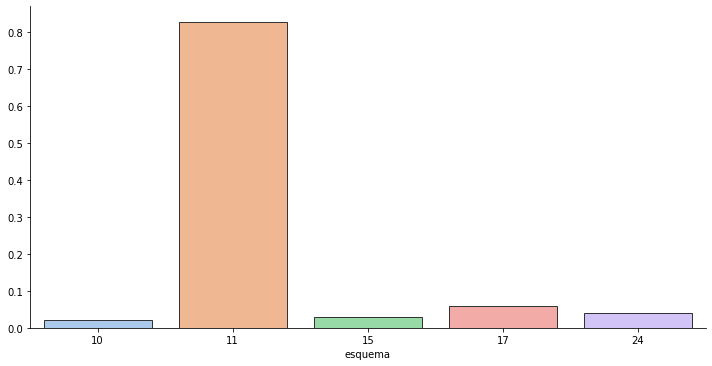

In [ ]:
df_plot = df_prep_notnull.copy()
df_plot['id'] = df_plot.index + 1
df_plot = df_plot.groupby('esquema')['id'].count().reset_index()
df_plot.columns = ['esquema', 'count']
df_plot['freq'] = df_plot['count'] / df_plot['count'].sum()
df_plot = df_plot[df_plot['freq'] > 0.01]

ax = sns.catplot(x="esquema", y="freq", kind="bar", palette="pastel", edgecolor=".2", data=df_plot, aspect=2.0)
ax.set(ylabel='')
#ax.set_xticklabels(rotation=90)

plt.show()

Podemos ver no gráfico que o esquema de tratamento 13 é o mais utilizado, seguido pelos tratamentos 17, 24, 15 2 e 10;

11: Infecções pelo P. vivax, ou P. ovale com Cloroquina em 3 dias e Primaquina em 7 dias

17: Infecções por P. falciparum com a combinação fixa de artemeter+lumefantrina em 3 dias

24: Outro Esquema utilizado

15: Infecções por P. falciparum com a combinação fixa de Artemeter + Lumefantrina em 3 dias e primaquina em dose única

10: Infecções pelo P. vivax, ou P. ovale com Cloroquina em 3 dias e Primaquina em 14 dias (esquema longo)

### Idades inconsistentes

## First Approach
Utilizar tratamento 11 contra o resto



In [ ]:
df_prep_fa = df_prep_notnull.copy()
df_prep_fa.head()

,tipo_lam,id_pacie,sexo,raca,sintomas,cod_ocup,mun_infe,loc_infe,res_exam,qtd_cruz,esquema,hemoparasi,exame,gestante,vivax,falciparum,niv_esco,zona_infe
1721039,0,26.0,1,3,0,0,120080.0,146.0,9,0,11,1,0,5,0,0,6,0
1721045,0,43.0,1,3,0,8,110020.0,86.0,9,4,10,2,0,5,0,0,8,1
1721063,0,28.0,1,3,0,8,110020.0,317.0,9,1,11,2,0,5,0,0,2,0
1721072,0,24.0,1,4,0,11,120001.0,34.0,9,1,11,1,0,5,0,0,2,0
1721086,0,16.0,0,3,0,3,120039.0,63.0,9,1,11,2,0,4,0,0,0,0


In [ ]:
df_prep_fa['target'] = np.where(df_prep_fa['esquema'] == 11, 1, 0)

In [ ]:
df_prep_fa.head()

,tipo_lam,id_pacie,sexo,raca,sintomas,cod_ocup,mun_infe,loc_infe,res_exam,qtd_cruz,esquema,hemoparasi,exame,gestante,vivax,falciparum,niv_esco,zona_infe,target
1721039,0,26.0,1,3,0,0,120080.0,146.0,9,0,11,1,0,5,0,0,6,0,1
1721045,0,43.0,1,3,0,8,110020.0,86.0,9,4,10,2,0,5,0,0,8,1,0
1721063,0,28.0,1,3,0,8,110020.0,317.0,9,1,11,2,0,5,0,0,2,0,1
1721072,0,24.0,1,4,0,11,120001.0,34.0,9,1,11,1,0,5,0,0,2,0,1
1721086,0,16.0,0,3,0,3,120039.0,63.0,9,1,11,2,0,4,0,0,0,0,1


In [ ]:
## Apagar a coluna esquema
df_prep_fa.drop(axis=1, columns=['esquema'], inplace=True)

In [ ]:
df_prep_fa.columns

Index(['tipo_lam', 'id_pacie', 'sexo', 'raca', 'sintomas', 'cod_ocup',
       'mun_infe', 'loc_infe', 'res_exam', 'qtd_cruz', 'hemoparasi', 'exame',
       'gestante', 'vivax', 'falciparum', 'niv_esco', 'zona_infe', 'target'],
      dtype='object')

In [ ]:
nRows = df_prep_fa.shape[0]
df_prep_fa['target'].value_counts()[1] / nRows

0.8277008292361229

In [ ]:
df_prep_fa['target'].value_counts()[0] / nRows

0.17229917076387719

In [ ]:
sns.set_theme(style="whitegrid")
plt.rcParams['figure.figsize'] = (10, 6)
plt.rcParams['axes.labelsize'] = 14
plt.rcParams['xtick.labelsize'] = 14
plt.rcParams['xtick.labelsize'] = 14
plt.rcParams['ytick.labelsize'] = 14

In [ ]:
data = df_prep_fa.groupby("target")["target"].count()
data

target
0     213453
1    1025398
Name: target, dtype: int64

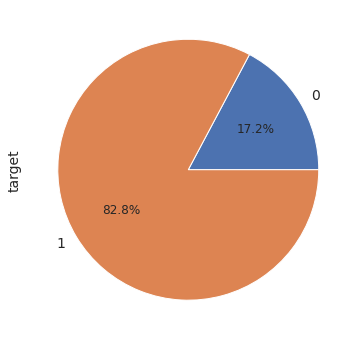

In [ ]:
data.plot.pie(autopct="%.1f%%");

### Dividir a base dados em treinamento e teste - 80/20
Dos 80% de treinamento, usar 20% para validação

In [ ]:
df_prep_fa.columns

Index(['tipo_lam', 'id_pacie', 'sexo', 'raca', 'sintomas', 'cod_ocup',
       'mun_infe', 'loc_infe', 'res_exam', 'qtd_cruz', 'hemoparasi', 'exame',
       'gestante', 'vivax', 'falciparum', 'niv_esco', 'zona_infe', 'target'],
      dtype='object')

In [ ]:
X_train, X_test = utl.train_test_split(df_prep_fa, test_size=0.20, random_state=13)
df_train = X_train.copy()
X_train, X_val = utl.train_test_split(X_train, test_size=0.20, random_state=13)

print('Amostra para treino: %s' % X_train.shape[0])
print('Amostra para validação: %s' % X_val.shape[0])
print('Amostra para teste: %s' % X_test.shape[0])

Amostra para treino: 792864
Amostra para validação: 198216
Amostra para teste: 247771


In [ ]:
y_train = X_train['target'].values
X_train = X_train.drop(['target'], axis=1)

y_val = X_val['target'].values
X_val = X_val.drop(['target'], axis=1)

In [ ]:
clf = DecisionTreeClassifier(random_state=27)
clf.fit(X_train, y_train)

DecisionTreeClassifier(ccp_alpha=0.0, class_weight=None, criterion='gini',
                       max_depth=None, max_features=None, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, presort='deprecated',
                       random_state=27, splitter='best')

In [ ]:
y_val_pred = clf.predict(X_val)
y_val_predProba = clf.predict_proba(X_val)

In [ ]:
generate_performance_stats(y_val, y_val_pred)

Accuracy: 0.8995994268878396

Auc: 0.8315717911112512

Confusion Matrix: 
Predicted      0       1
Actual                  
0          24999    9367
1          10534  153316

Classification Report: 
                  precision    recall  f1-score   support

Outro Tratamento       0.70      0.73      0.72     34366
   Tratamento 11       0.94      0.94      0.94    163850

        accuracy                           0.90    198216
       macro avg       0.82      0.83      0.83    198216
    weighted avg       0.90      0.90      0.90    198216




Normalized confusion matrix


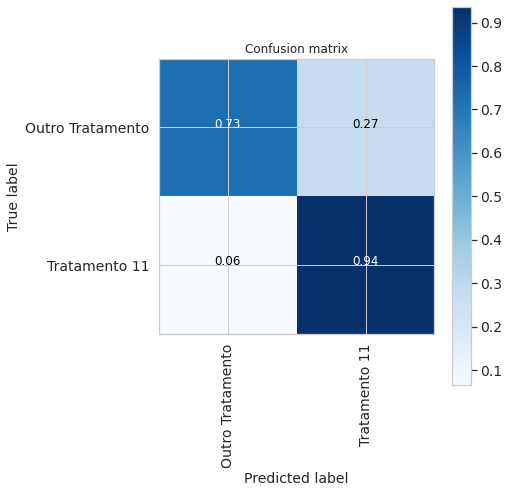

In [ ]:
plt.figure(figsize=(7,7))
cm = metrics.confusion_matrix(y_val, y_val_pred)
utl.plot_confusion_matrix(cm, ['Outro Tratamento', 'Tratamento 11'], normalize=True)

In [ ]:
df_featImport = pd.DataFrame(columns=['feature', 'feat_importance'])

In [ ]:
df_featImport['feature'] = X_val.columns
df_featImport['feat_importance'] = clf.feature_importances_
df_featImport = df_featImport.sort_values(by='feat_importance', ascending=False)
df_featImport

,feature,feat_importance
8,res_exam,0.570048
1,id_pacie,0.102356
7,loc_infe,0.092021
6,mun_infe,0.068722
15,niv_esco,0.039347
9,qtd_cruz,0.035056
12,gestante,0.022247
5,cod_ocup,0.021779
3,raca,0.012938
2,sexo,0.010842


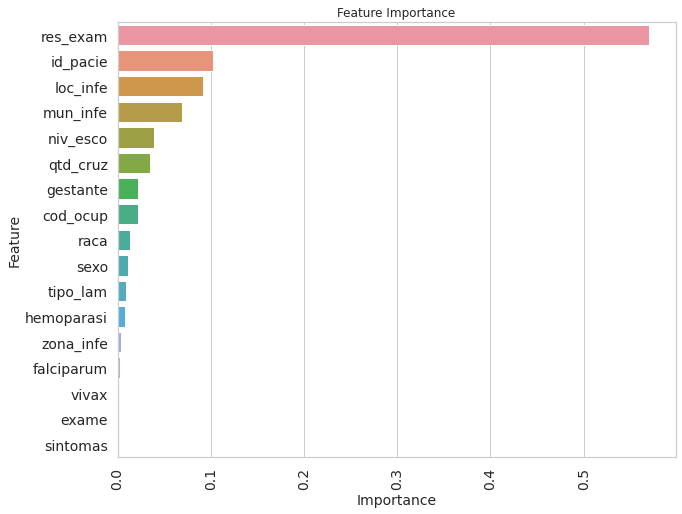

In [ ]:
plt.figure(figsize=(10, 8))
sns.barplot(data=df_featImport, x='feat_importance', y='feature')
plt.xticks(rotation=90)
plt.xlabel('Importance')
plt.ylabel('Feature')
plt.title('Feature Importance')
plt.show()

### Aplicar validação cruzada no conjunto de treinamento

In [ ]:
models = {
    'XGBoost': XGBClassifier(),
    'Logistic': LogisticRegression(),
    'DecisionTree': DecisionTreeClassifier()
    #'SVM': SVC(gamma='auto')
    #'RF': RandomForestClassifier(n_estimators=100,criterion='gini'),
}

In [ ]:
n_folds = 5
results_exp1, models_pred_exp1 = utl.perform_cv(df_train, models, n_folds, True)

Model: XGBoost

Fold[1]

Fold[2]

Fold[3]

Fold[4]

Fold[5]

Accuracy: 0.914599225087783

Auc: 0.8425311767191789

Confusion Matrix: 
Predicted     0.0     1.0
Actual                   
0.0        138799   52621
1.0         32018  767642

Classification Report: 
                  precision    recall  f1-score   support

Outro Tratamento       0.81      0.73      0.77    191420
   Tratamento 11       0.94      0.96      0.95    799660

        accuracy                           0.91    991080
       macro avg       0.87      0.84      0.86    991080
    weighted avg       0.91      0.91      0.91    991080


########################################################

Model: Logistic

Fold[1]



[WARNING] /usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)



Fold[2]

Fold[3]

Fold[4]



[WARNING] /usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)



Fold[5]

Accuracy: 0.8942719053961335

Auc: 0.8174748437448628

Confusion Matrix: 
Predicted     0.0     1.0
Actual                   
0.0        114249   48217
1.0         56568  772046

Classification Report: 
                  precision    recall  f1-score   support

Outro Tratamento       0.67      0.70      0.69    162466
   Tratamento 11       0.94      0.93      0.94    828614

        accuracy                           0.89    991080
       macro avg       0.81      0.82      0.81    991080
    weighted avg       0.90      0.89      0.90    991080


########################################################

Model: DecisionTree

Fold[1]

Fold[2]

Fold[3]

Fold[4]

Fold[5]

Accuracy: 0.8356671509868023

Auc: 0.738299662504905

Confusion Matrix: 
Predicted     0.0     1.0
Actual                   
0.0        144101  136151
1.0         26716  684112

Classification Report: 
                  precision    recall  f1-score   support

Outro Tratamento       0.84      0.51      0.64    

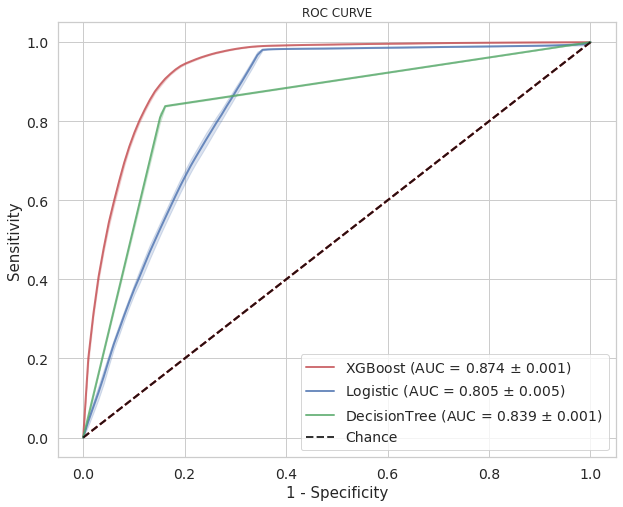

In [ ]:
plot_roc_curve(results_exp1, "roc_curve_balanced_5kfold")

In [ ]:
for idx, result in enumerate(results_exp1):
  print(idx)
  print(result.model_name)
  print(len(result.y_pred))
len(results_exp1)

0
XGBoost
991080
1
Logistic
991080
2
DecisionTree
991080


3

In [ ]:
print(int(7 / 2))
3 % 2

3


1

In [ ]:
def plot_confusion_matrix(results, classes=[''],
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):

  nRows = (len(results) % 2)
  if (len(results) % 2) != 0:
    nRows = (len(results) % 2) + 1

  fig, axs = plt.subplots(nrows=nRows, ncols=2, sharex=True, sharey=True)
  for idx, result in enumerate(results):
    print(idx)

    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    cm = confusion_matrix(result.y_test, result.y_pred)
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=90)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

  plt.tight_layout()
  plt.ylabel('True label')
  plt.xlabel('Predicted label')


NameError: ignored

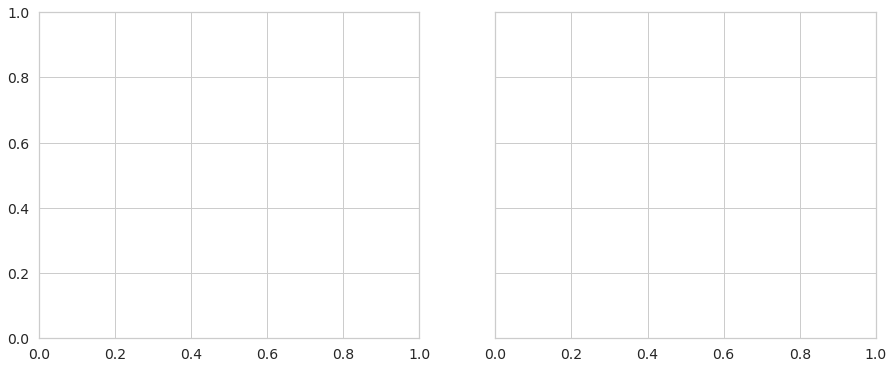

In [ ]:
fig, axs = plt.subplots(nrows=1, ncols=2, sharex=True, sharey=True, figsize=(15,6))

classes=['Outro Tratamento', 'Tratamento 11']
cm = confusion_matrix(results_exp1[0].y_test, results_exp1[0].y_pred)
cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
sns.heatmap(cm, annot=True, annot_kws={"size": 16}, cmap=plt.cm.Blues, ax=axs[0]) # font size

tick_marks = np.arange(len(classes))
plt.xticks(tick_marks, classes, rotation=90)
plt.show()

In [ ]:
plot_confusion_matrix(results_exp1, classes=['Outro Tratamento', 'Tratamento 11'])